In [21]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import helpers
import pandas as pd
import seaborn as sns

plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
data = helpers.load_data('../vertex_finding/data/train/RapidVPData_6915602_43502.json')
df = helpers.extract_tracks(data)
hits = helpers.extract_hits(data)
mc = helpers.extract_mc(data)
zs = df['z'].values.reshape(-1, 1)

In [3]:
counts, centers, widths = helpers.make_histogram(zs)

In [4]:
peak_counts, peak_centers, _ = helpers.make_histogram(zs, bins=np.arange(-120, 120, 4))
peaks = helpers.find_peaks(peak_counts, peak_centers, height=5)

In [5]:
clusters = helpers.find_clusters(zs, eps=2.9625)

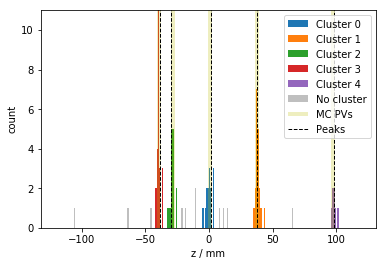

In [6]:
m = max(counts)

plt.vlines(mc.z[mc.products > 5], 0, m, color='y', linewidth=4, alpha=0.25, label='MC PVs')
plt.vlines(peaks, 0, m, color='k', linewidth=1, linestyle='dashed', label='Peaks')

for l in np.unique(clusters[clusters != -1]):
    plt.hist(zs[clusters == l], bins=np.arange(-120, 120, 1), label=f'Cluster {l}')
plt.hist(zs[clusters == -1], bins=np.arange(-120, 120, 1), color='k', alpha=0.25, label='No cluster')
plt.legend(loc='best')
plt.xlabel('z / mm')
plt.ylabel('count')
_ = plt.ylim(0, m)

Values for eps and height, as well as binning used for peak finding are the result of a discussion with Niklas.

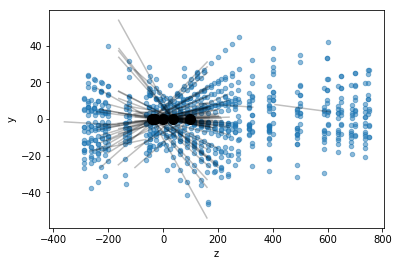

In [7]:
hits.plot.scatter(x='z', y='y', alpha=.5)
for _, x in df.iterrows():
    factor = (x.isBackwards * -2 + 1) * 200
    plt.plot([x.z, x.z + factor], [x.y, x.y + x.dy * factor ], color='k', alpha=0.25)

ps = plt.scatter(mc.z, mc.y, color='k', alpha=1, s=100)
ps.zorder = 100

In [8]:
import glob

def load_all(filename):
    data = helpers.load_data(filename)
    return helpers.match_tracks_mc(
        helpers.extract_tracks(data),
        helpers.extract_hits(data),
        helpers.extract_mcpv(data),
        helpers.extract_mc(data)
    )

In [9]:
files = glob.glob('../vertex_finding/data/train/*.json')
df = pd.concat([load_all(f) for f in files])

In [10]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy import interp

In [11]:
df = helpers.generate_features(df)

In [12]:
df.columns

Index(['LHCbIDs', 'MCPs', 'isBackwards', 'key_x', 'x', 'y', 'z', 'dx', 'dy',
       'cov_x', 'cov_y', 'cov_dx', 'cov_dy', 'cov_xdx', 'MCP', 'firstHit',
       'MCPsFirstHit', 'keyFirstHit', 'xFirstHit', 'yFirstHit', 'zFirstHit',
       'PV', 'key_y', 'key', 'products', 'xPV', 'yPV', 'zPV', 'zdiff', 'close',
       'rho'],
      dtype='object')

In [13]:
def model():
    return RandomForestClassifier(n_estimators=10, max_depth=7)
    #return ExtraTreesClassifier(n_estimators=100, max_depth=7)

features = ['x', 'y', 'z',
            'dx', 'dy',
            'cov_x', 'cov_y',
            'cov_dx', 'cov_dy', 'cov_xdx',
            'xFirstHit', 'yFirstHit', 'zFirstHit',
            'rho', 'isBackwards']
label = 'close'

n_rows = -1
X = df[features].values[:n_rows]
y = df[label].values[:n_rows]

pd.value_counts(y) / len(y) * 100

True     79.93054
False    20.06946
dtype: float64

In [14]:
cv = StratifiedKFold(10, shuffle=True)
#cv = KFold(10, shuffle=True)
cms_train = []
cms_test = []
roc_train = []
roc_test = []
models = []

for train, test in cv.split(X, y):
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    m = model().fit(X_train, y_train)
    models.append(m)
    # Confusion matrices
    cms_train.append(confusion_matrix(y_train, m.predict(X_train)))
    cms_test.append(confusion_matrix(y_test, m.predict(X_test)))
    # ROC curves
    roc_train.append(roc_curve(y_train, m.predict_proba(X_train)[:, 1]))
    roc_test.append(roc_curve(y_test, m.predict_proba(X_test)[:, 1]))

In [15]:
def mean_cm(cms):
    cms = [cm / cm.sum() * 100 for cm in cms]
    cm_mean = np.mean(cms, axis=0)
    cm_std = np.std(cms, axis=0)
    return cm_mean, cm_std

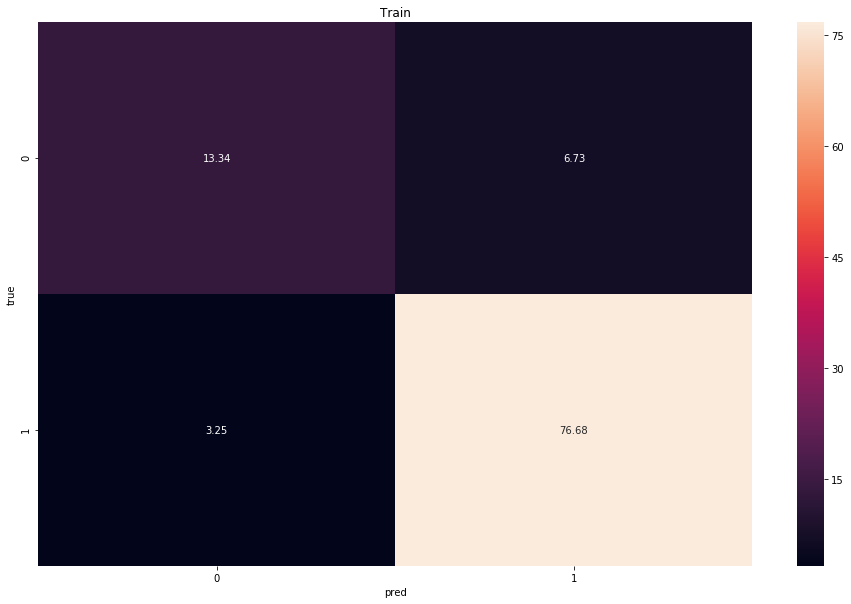

In [22]:
mean_cm_train, std_cm_train = mean_cm(cms_train)
sns.heatmap(mean_cm_train, annot=True, fmt='.2f')
plt.xlabel('pred')
plt.ylabel('true')
_ = plt.title('Train')

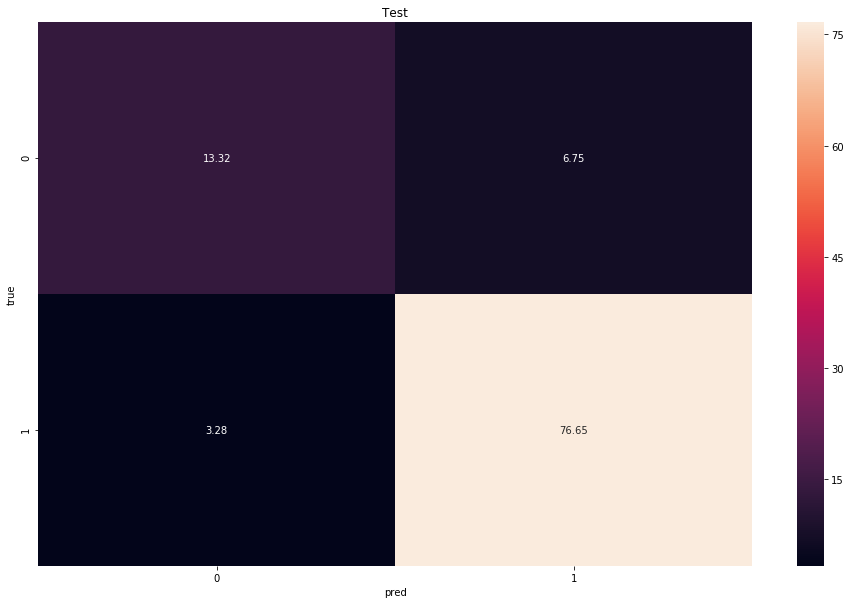

In [23]:
mean_cm_test, std_cm_test = mean_cm(cms_test)
sns.heatmap(mean_cm_test, annot=True, fmt='.2f')
plt.xlabel('pred')
plt.ylabel('true')
_ = plt.title('Test')

In [24]:
def plot_rocs(rocs, sample, color, mean_color):
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for i, (fpr, tpr, _) in enumerate(rocs):
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, c=color,
                 label=f'{sample} ROC fold {i} (AUC = {roc_auc:.2f})')
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color=mean_color,
             label=f'{sample} mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})',
             lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=mean_color, alpha=.2,
                     label=f'$\pm$ 1 std. dev.')

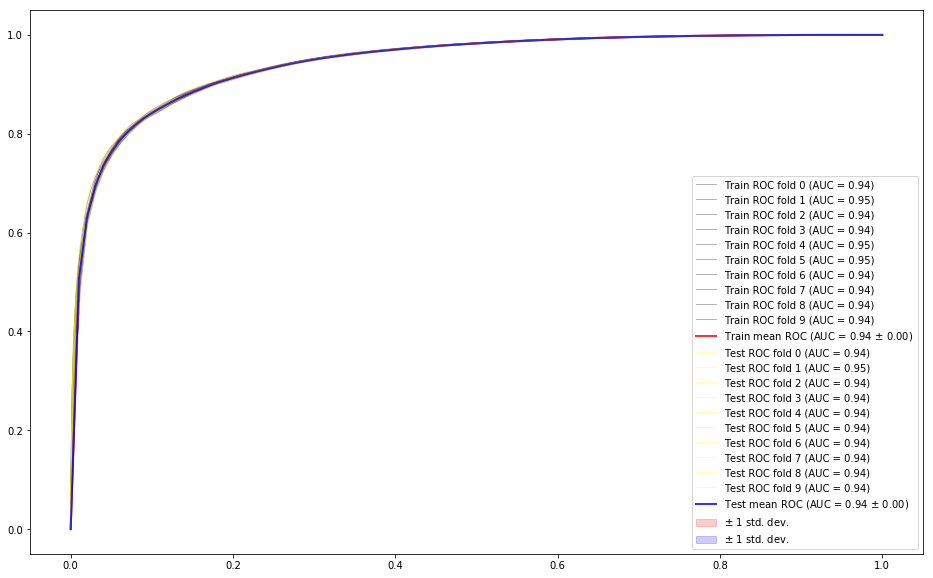

In [25]:
plot_rocs(roc_train, 'Train', 'black', 'red')
plot_rocs(roc_test, 'Test', 'yellow', 'blue')
plt.legend(loc='best')

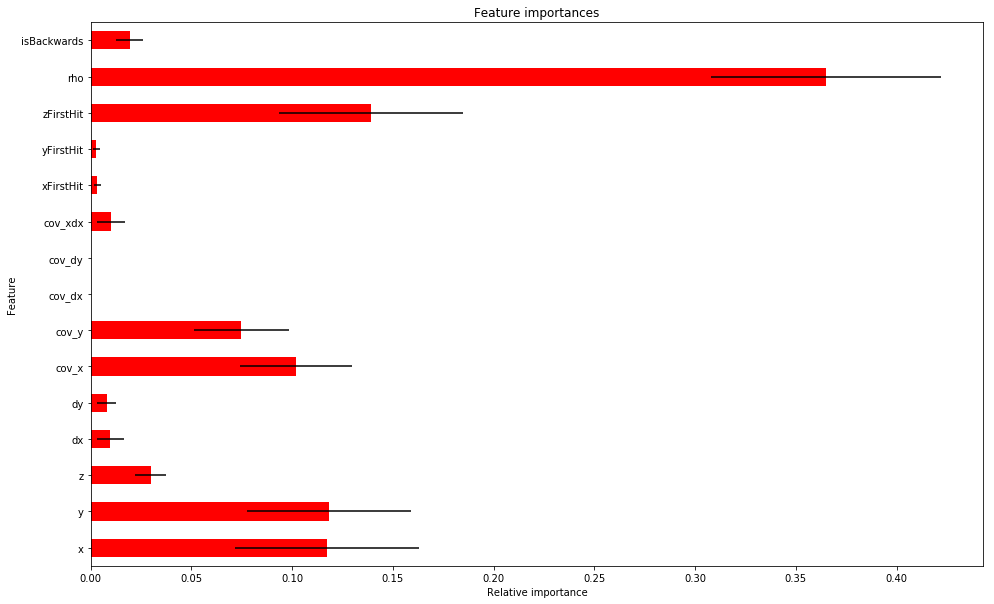

In [26]:
feature_importances = pd.DataFrame([m.feature_importances_ for m in models], columns = features)
feature_importances.mean().plot.barh(xerr=feature_importances.std(), color='r')
plt.xlabel('Relative importance')
plt.ylabel('Feature')
_ = plt.title('Feature importances')